# LQR control of learned dynamics for pendulum

## Pendulum simulation with a control input $u$

$$\frac{1}{2}m L^2 \ddot{\theta} + mg sin(\theta) = u$$ <br> 

With $u$ being the torque applied on the pendulum rotation center. Now, the goal is to simulate this system for given inputs $u$ and store the values for both
$u$ and the states. But first, transform to state-space.

In [57]:
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import Utils.Functions 
reload(Utils.Functions)
from Utils.Functions import *
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5

def Pendulum(theta, u, params):
    
    g = 9.81
    m = params["mass"]
    l = params["length"]
    x1 = theta[0]
    x2 = theta[1]
    dx1dt = x2
    dx2dt = 2/(m*l**2)*(u - m*g*np.sin(x1))
    dxdt = np.array([dx1dt, dx2dt])
     
    return dxdt

Now simulate and plot the pendulum trajectory using a pre-defined torque input $u$ and integrate using a *Runge-Kutta 4* integrator to retrieve the states, i.e. $x_1 = \theta$, 
$x_2 = \dot{\theta}$ and $x_3 = \ddot{\theta}$.

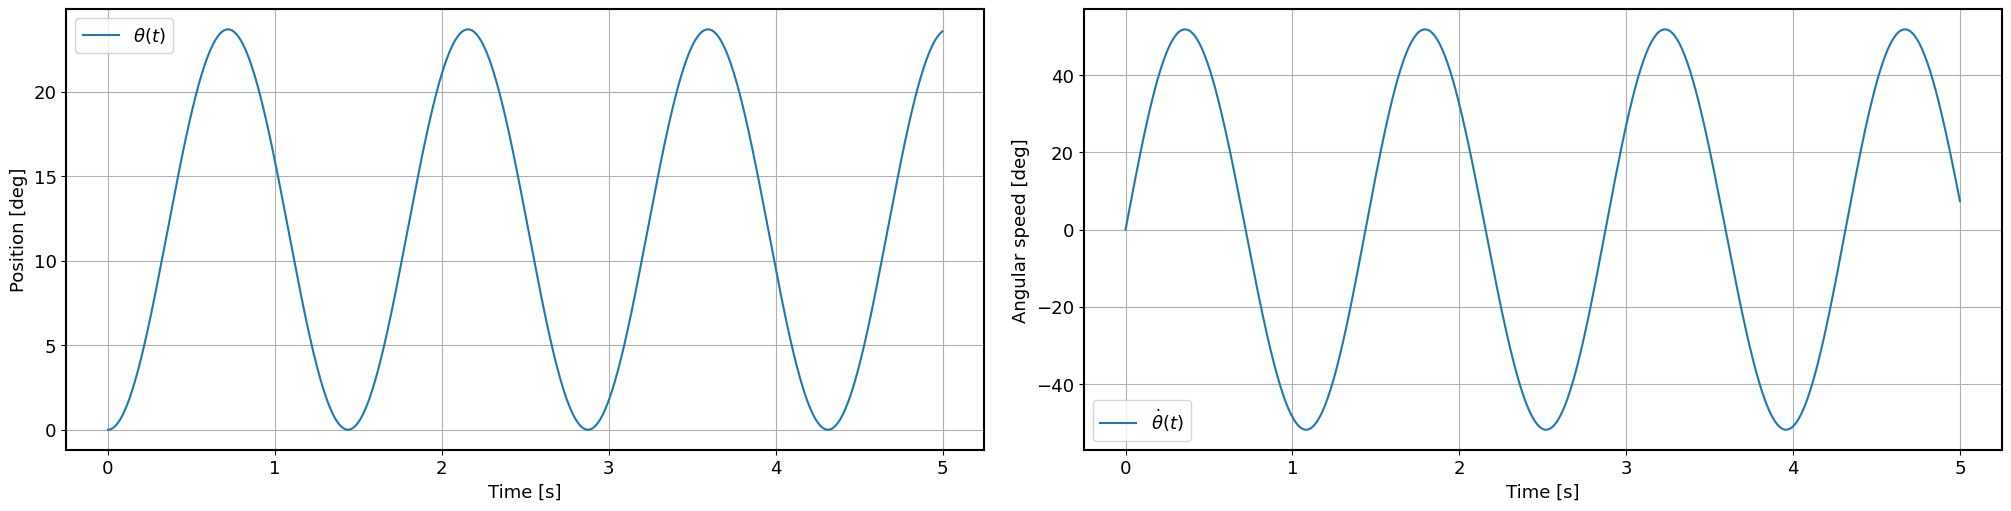

In [3]:
# Parameters 
X0 = np.array([deg2rad(0), 0]) # Initial condition (horizontal)
t = np.arange(0.0,5,0.001) # Time horizon
torque = 2*np.ones([t.shape[0]]) # Control input [Nm]
params = {"mass":1, "length":1}

# Simulation
f = lambda x, t, u : Pendulum(x, u, params) # Pass parameters to the lambda function
X = RK4(f, X0, torque, t)
torque = torque[:,np.newaxis] # For later on

# Plots
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(t, 180/np.pi*X[0,:], label=r"$\theta (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, 180/np.pi*X[1,:], label=r"$\dot{\theta} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

## Linear dynamics learning

Now, we can find an approximate linear representation of the non-linear pendulum dynamics using the Least-Square algorithm. We try to represent the dynamics as follows : <br><br>
$$\begin{pmatrix} x_1(k+1) \\ x_2(k+1) \end{pmatrix} = \begin{pmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{pmatrix} \begin{pmatrix} x_1(k) \\ x_2(k) \end{pmatrix} + \begin{pmatrix} B_{1} \\ B_{2} \end{pmatrix} u(k)$$ <br><br>

The matrices $A$ and $B$ can be put together, yielding a linear regression problem. Also, many observations can be used. However, in order to construct a least square problem, the right-hand side can be inverted as follows : <br><br>

$$\begin{pmatrix} x_1(1) & x_2(1) \\ \vdots & \vdots \\ x_1(T) & x_2(T) \end{pmatrix} = \begin{pmatrix} x_1(0) & x_2(0) & u(0) \\ \vdots & \vdots & \vdots \\ x_1(T-1) & x_2(T-1) & u(T-1) \end{pmatrix} \begin{pmatrix} A_{11} & A_{21} \\ A_{12} & A_{22} \\ B_1 & B_2 \end{pmatrix}$$ <br><br>

Now, let's write the least square problem, $\theta$ being the *parameter* vector, $\Phi$ the *observations* vector and $Y$ the *measurement* vector : <br><br>

$$\bar{A} \bar{X} = \bar{Y} \Longleftrightarrow \bar{X}^T \bar{A}^T = \bar{Y}^T \Longleftrightarrow \Phi \theta = Y$$

$$ \hat{\theta} = (\Phi^T \Phi)^{-1} \Phi^T Y $$

In [4]:
from numpy.linalg import inv

# Create delayed state evolution matrices
Y = (X[:,1:X.shape[1]]).T
Phi = np.concatenate((X[:,0:X.shape[1]-1].T, torque[0:torque.shape[0]-1]), axis=1)

# Compute the estimated parameters
theta_hat = (inv(Phi.T@Phi)@Phi.T@Y).T
print(theta_hat)

[[ 9.99990449e-01  9.99995358e-04  9.91148481e-07]
 [-1.91017712e-02  9.99987533e-01  1.98229027e-03]]


In [5]:
def smallAnglePendulum(theta, u, params):
    
    g = 9.81
    m = params["mass"]
    l = params["length"]
    x1 = theta[0]
    x2 = theta[1]
    dx1dt = x2
    dx2dt = 2/(m*l**2)*(u - m*g*x1)
    dxdt = np.array([dx1dt, dx2dt])
     
    return dxdt

Now, let's compare these linear dynamics with the original, non-linear dynamics. Let's also compare this with the small-angle approximation of the pendulum dynamics : <br><br>
$$\frac{1}{2}m L^2 \ddot{\theta} + mg \theta = u$$ <br><br>
And then simulate it along its non-linear counterpart.

(2, 2) (2,) [[ 0.99999045  0.001     ]
 [-0.01910177  0.99998753]] [9.91148481e-07 1.98229027e-03]


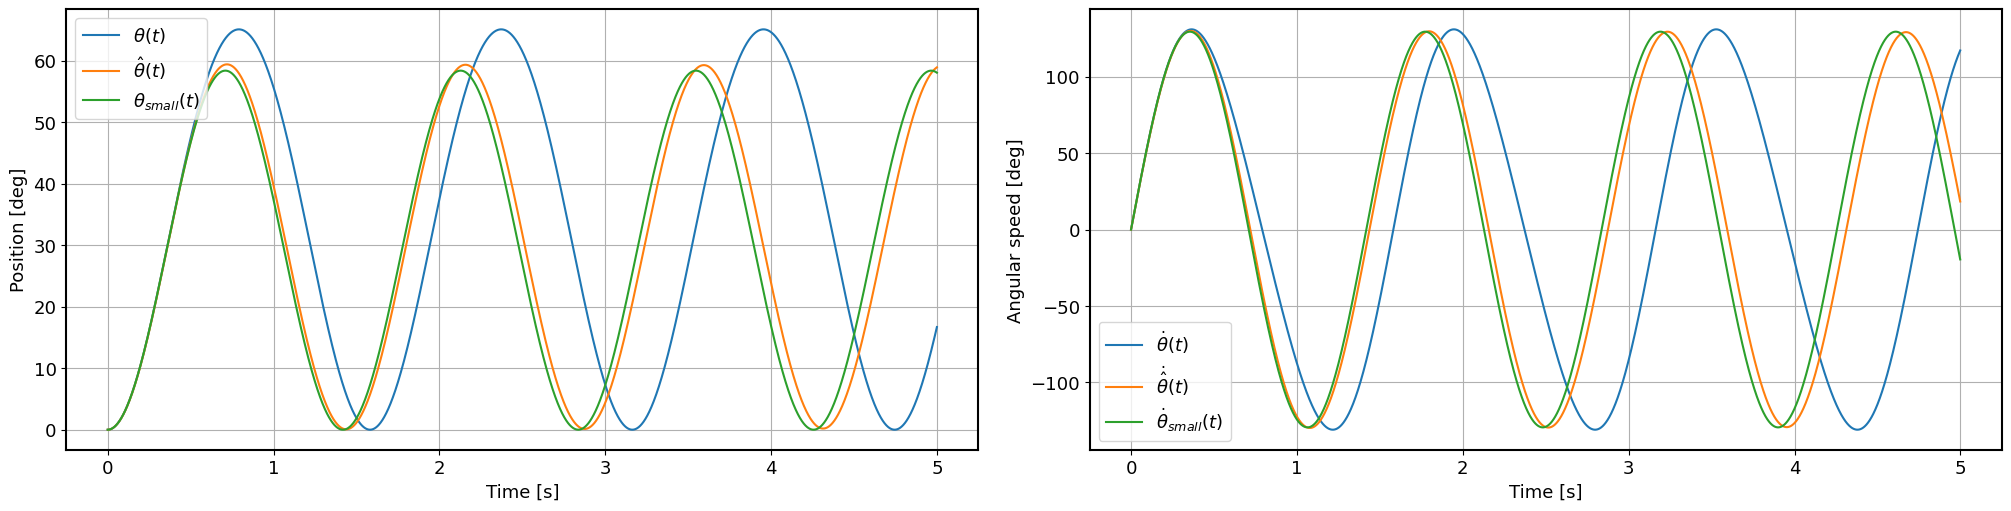

In [6]:
# Linear & non-linear simulations
import Utils.Functions 
reload(Utils.Functions)
from Utils.Functions import *

# Parameters 
X0 = np.array([deg2rad(0), 0]) # Initial condition (horizontal)
t = np.arange(0.0,5,0.001) # Time horizon
torque = 5*np.ones([t.shape[0]]) # Control input [Nm]
params = {"mass":1, "length":1}
A = theta_hat[:,0:2]
B = theta_hat[:,2:3][:,0]
print(A.shape, B.shape, A, B)

# Simulation
f_hat = lambda x, t, u : linPendulum(x, theta_hat, u, params) # Pass parameters to the lambda function
f_small = lambda x, t, u : smallAnglePendulum(x, u, params) # Pass parameters to the lambda function
X = RK4(f, X0, torque, t)
X_hat = discreteSimulation(A, B, X0, torque, t)
X_small = RK4(f_small, X0, torque, t)

# Plots
fig, ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(t, 180/np.pi*X[0,:], label=r"$\theta (t)$")
ax[0].plot(t, 180/np.pi*X_hat[0,:], label=r"$\hat{\theta} (t)$")
ax[0].plot(t, 180/np.pi*X_small[0,:], label=r"$\theta_{small} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, 180/np.pi*X[1,:], label=r"$\dot{\theta} (t)$")
ax[1].plot(t, 180/np.pi*X_hat[1,:], label=r"$\dot{\hat{\theta}} (t)$")
ax[1].plot(t, 180/np.pi*X_small[1,:], label=r"$\dot{\theta}_{small} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

## LQR control of the linearly learned pendulum

In [1]:
import os
import sys
import importlib  
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
pbd_path = os.path.abspath(os.path.join('pbdlib-python'))
sys.path.append(pbd_path)
pbd_path = os.path.abspath(os.path.join('pbdlib'))
sys.path.append(pbd_path)
import pbdlib as pbd
%load_ext autoreload
%autoreload 2

### LQR problem parameters

In [7]:
B = B[:,np.newaxis]

In [24]:
T = 5 # Time horizon [s]
N = 1000 # Horizon (nb. of steps)
dt = T/1000
lqr = pbd.LQR(A, B, nb_dim=A.shape[0], dt=dt, horizon=N)
x_dim = 2
nb_deriv = 1

# Set via-points and target
viaPoint1 = np.array([deg2rad(20), 0, 0, 0])[:x_dim*nb_deriv]
viaPoint2 = np.array([deg2rad(40), 0, 0, 0])[:x_dim*nb_deriv]
x_final_target = np.array([deg2rad(40), 0, 0, 0])[:x_dim*nb_deriv] # i.e go to a certain angle and stay there

zs = np.stack([
        viaPoint1,
        viaPoint1,
        viaPoint2,
        viaPoint2,
        x_final_target,
        x_final_target
    ]) # these are double because we will assign 0 precision for the first one, and bigger precision for the other

lqr.z = zs

# Setting via-points timing
viaTime1 = int(N*0.4)
viaTime2 = int(N*0.7)
#seq =  ((via_time1-1) * [0] + 1 * [1] + (via_time2-via_time1-1)* [2] + 1 * [3] +(horizon-via_time2-1)*[4] + 1*[5] )
seq = ((viaTime1-1)*[0] + 1*[1] + (viaTime2-viaTime1-1)*[2] + 1*[3] + (N-viaTime2-1)*[4] + 1*[5])
lqr.seq_xi = seq

# Control precision 
u_std = -3. # means 1e-3
lqr.gmm_u = u_std

# Tracking precision
x_std = 1e6 # Importance of tracking the position
dx_std = 1e2 # Importance of tracking the velocity
Qs = np.stack([
    np.diag([0., 0.]),
    np.diag([x_std, x_std]),
    np.diag([0., 0.]),
    np.diag([x_std, x_std]),
    np.diag([0., 0.]),
    np.diag([x_std, x_std])
    ])
lqr.Q = Qs

[[ 0.99999045  0.001     ]
 [-0.01910177  0.99998753]]


### Solve the LQR problem 

In [25]:
lqr.ricatti()

### Plotting the results using the linear dynamics

(1000,)


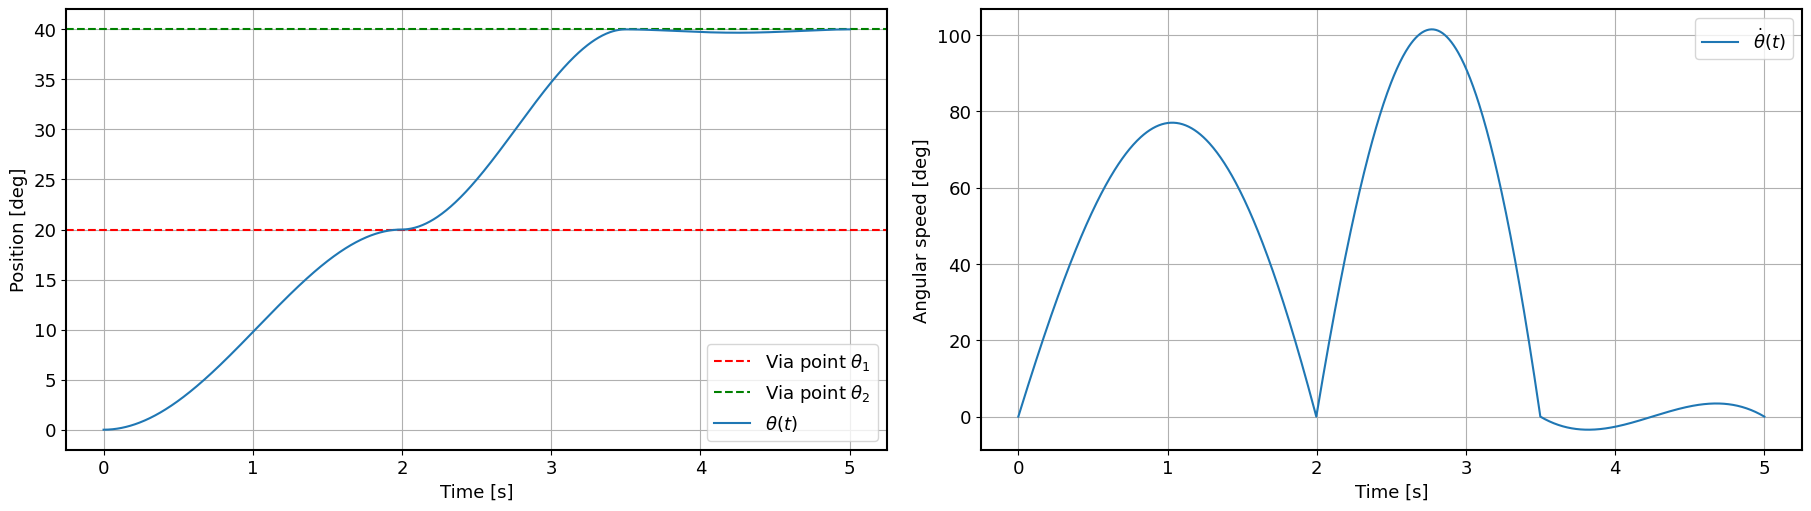

In [26]:
# Simulate the closed-loop system
demo_number = 2
x0 = np.zeros((demo_number, x_dim*nb_deriv))
xs,us = lqr.make_rollout(x0)
t = np.linspace(0,T,N)

# Plot
fig,ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(18,5))
xs_mean = np.mean(xs, axis=0) 
xs_std  = np.std(xs, axis=0)

ax[0].axhline(y=rad2deg(viaPoint1[0]), linestyle='--', color='r', label=r"Via point $\theta_1$")
ax[0].axhline(y=rad2deg(viaPoint2[0]), linestyle='--', color='g', label=r"Via point $\theta_2$")

ax[0].plot(t, rad2deg(xs_mean[:,0]), label=r"$\theta (t)$")
#ax[0].plot(t, 180/np.pi*X_hat[0,:], label=r"$\hat{\theta} (t)$")
#ax[0].plot(t, 180/np.pi*X_small[0,:], label=r"$\theta_{small} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, rad2deg(xs_mean[:,1]), label=r"$\dot{\theta} (t)$")
#ax[1].plot(t, 180/np.pi*X_hat[1,:], label=r"$\dot{\hat{\theta}} (t)$")
#ax[1].plot(t, 180/np.pi*X_small[1,:], label=r"$\dot{\theta}_{small} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

### Simulating the system with the real dynamics
The simulation above yields perfect results because the same linear dynamics were used both for controller design and simulation. However, what we rather want to do is design a linear controller (LQR) using linear(ised) dynamics and the apply them to the *real* system, i.e. the non-linear dynamics in the simulation.<br>

Note that we use a finite-horizon LQR controller here, meaning that the control gain changes at each time-step. The following function can be used to retrieve the control input at time-step $i$ : $get\_command(x_i, i)$.

[5.57616044]


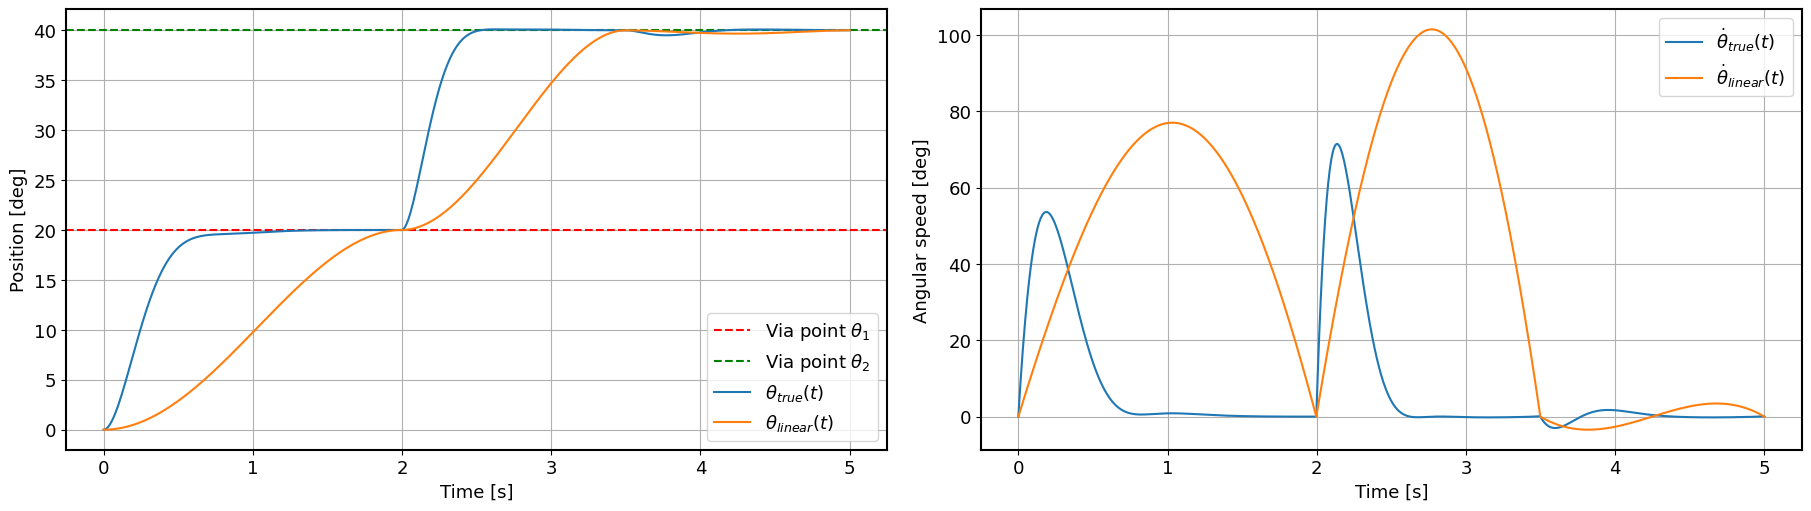

In [60]:
X0 = np.array([0,0]) # Initial condition : [position [rad], velocity [rad/s]]
t_interval = np.array([dt]) # Time-interval for one step to occur
Xc = np.empty(shape=[N,2]) # Controlled trajectory
Xc[0,:] = X0
print(lqr.get_command(X0, 0))
for i in range(0):
    print(i)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(N-1):
    
    u = lqr.get_command(Xc[i,:], i) # Retrieve LQR control input
    Xc[i+1,:] = RK4(f, Xc[i,:], u, t_interval).T[1,:] # Next point of the non-linear controlled trajectory
    
# Plot trajectory
fig,ax = plt.subplots(1, 2, 
                       constrained_layout = True, figsize=(18,5))

ax[0].axhline(y=rad2deg(viaPoint1[0]), linestyle='--', color='r', label=r"Via point $\theta_1$")
ax[0].axhline(y=rad2deg(viaPoint2[0]), linestyle='--', color='g', label=r"Via point $\theta_2$")

ax[0].plot(t, rad2deg(Xc[:,0]), label=r"$\theta_{true} (t)$")
ax[0].plot(t, rad2deg(xs_mean[:,0]), label=r"$\theta_{linear} (t)$")
#ax[0].plot(t, 180/np.pi*X_hat[0,:], label=r"$\hat{\theta} (t)$")
#ax[0].plot(t, 180/np.pi*X_small[0,:], label=r"$\theta_{small} (t)$")
ax[0].set_xlabel('Time [s]'), ax[0].set_ylabel('Position [deg]')
ax[0].grid()
ax[0].legend()

ax[1].plot(t, rad2deg(Xc[:,1]), label=r"$\dot{\theta}_{true} (t)$")
ax[1].plot(t, rad2deg(xs_mean[:,1]), label=r"$\dot{\theta}_{linear} (t)$")
#ax[1].plot(t, 180/np.pi*X_hat[1,:], label=r"$\dot{\hat{\theta}} (t)$")
#ax[1].plot(t, 180/np.pi*X_small[1,:], label=r"$\dot{\theta}_{small} (t)$")
ax[1].set_xlabel('Time [s]'), ax[1].set_ylabel('Angular speed [deg]')
ax[1].grid()
ax[1].legend()

### Short summary of finite-horizon discrete-time LQR
The finite horizon discrete-time LQR problem can be set up this way.<br><br>
$$J(x,u) = min_u \ \sum_{k=0}^{N} x_k^{T}Qx_k + u_k^{T}Ru_k$$ <br>
$$ s.t. \ x_{k+1} = Ax_k + Bu_k$$<br>
The goal is then to use *dynamic programming* to divise the cost function into part which can be optimised for dynamically, each one depending on those whose index $k$ is greater. Also, the cost should be positive semi-definite : $V_{i+1}(x_{i+1}) = x^{T}_{i+1}H_{i+1}x_{i+1}$ with $H_{i+1}$ PSD. Hence, start from $N$ and go backwards. Thus, first minimise $V(x_N,u_N) = x^{T}_N Q x_N$, $u_N$ being 0 since we don't need to go further (finite horizon). Since $V(x_N) = x^{T}_NH_Nx_N$, we know that $H_N = Q$.<br><br>
So from any DP iteration, we get a cost like : $V_i(x_i) = x^{T}_iQx_i + u^{T}_iRu_i + V(x_{i+1})$ with $V(x_{i+1}) = V(Ax_i + Bu_i) = (Ax_i + Bu_i)^{T}H_i(Ax_i + Bu_i)$. <br><br>
Hence, each of those costs can be optimised (i.e. derived with respect to $u_i$ in order to find $u^{\ast}_i$), leading to am expression of the form $u^{\ast}_i = K_i x_i$ with $K_i$ depending on $A$, $B$, $Q$, $R$ and $H_{i+1}$. However, since we go backwards and we know $H_N$, we recursively know $H_i$. <br><br>
In the reality, we only use $u^{\ast} = K_0 x_0$, the other $K_i$ only being used for planning (for using LQR in an unconstrained MPC fashion).

### Short summary of infinite-horizon discrete-time LQR

Since $V_i(x_i) = min_{u_i}(J(x_i,u_i)) + V_{i+1}(x_{i+1})$, we know that $V_i \ge V_{i+1}$. Hence, whenever $V_i = V_{i+1}$, it must hold that $V_j = V_{i+1}$ for any $j \le i$ (since we go backwards). <br><br>

Now, for a quadratic cost $V = x^T P x$, we have that $x^TPx = min_u \ ( x^TQx + u^TRu + (Ax + Bu)^TP(Ax + Bu))$. By deriving that w.r.t $u$, one can get $u^{\ast}(P)$, which can then be replaced in the original equation to retrieve an expression for $P$ (the equation being called de DARE). Then we only need to replace $P$ in $u^{\ast}(P)$ to get our unique control input $u^{\ast} = Kx$.